In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from networks.gan import Generator, Discriminator

Matplotlib is building the font cache; this may take a moment.


## GAN Structure

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 100

In [3]:
discr = Discriminator(image_dim).to(device)
genr = Generator(z_dim, image_dim).to(device)

In [5]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [6]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)

In [7]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

9913344it [00:04, 2146471.83it/s]                             
Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

29696it [00:00, 2757878.17it/s]          Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


1649664it [00:00, 2617016.34it/s]                             
Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

5120it [00:00, 3019096.93it/s]          Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw




## Training

In [11]:
opt_disc = optim.Adam(discr.parameters(), lr=lr)
opt_gen = optim.Adam(genr.parameters(), lr=lr)
criterion = nn.BCELoss()

In [14]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        ### Train Discriminator: maximize => log(D(x)) + log(1 - D(G(z)))
        
        ### z = a random noise, x = real sample, D is denoted by the discriminator
            
        noise = torch.randn(batch_size, z_dim).to(device)
        
        fake = genr(noise)
        
        disc_real = discr(real).view(-1)
        
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = discr(fake).view(-1)
        
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_real + lossD_fake) / 2
        
        
        discr.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        ## Train Generator
        
        output = discr(fake).view(-1)
        
        lossG = criterion(output, torch.ones_like(output))
        
        genr.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

    

Epoch [0/100] Batch 0/1875                       Loss D: 0.7126, loss G: 2.1964
Epoch [1/100] Batch 0/1875                       Loss D: 1.2448, loss G: 1.3198
Epoch [2/100] Batch 0/1875                       Loss D: 0.9488, loss G: 0.8118
Epoch [3/100] Batch 0/1875                       Loss D: 0.4727, loss G: 1.7340
Epoch [4/100] Batch 0/1875                       Loss D: 0.6711, loss G: 1.7042
Epoch [5/100] Batch 0/1875                       Loss D: 0.5197, loss G: 1.4521
Epoch [6/100] Batch 0/1875                       Loss D: 0.3440, loss G: 2.9519
Epoch [7/100] Batch 0/1875                       Loss D: 0.7628, loss G: 1.6392
Epoch [8/100] Batch 0/1875                       Loss D: 0.5411, loss G: 1.5654
Epoch [9/100] Batch 0/1875                       Loss D: 0.6765, loss G: 0.9784
Epoch [10/100] Batch 0/1875                       Loss D: 0.4152, loss G: 2.3134
Epoch [11/100] Batch 0/1875                       Loss D: 0.3937, loss G: 1.7733
Epoch [12/100] Batch 0/1875           

## Passing random noise to our model

In [15]:
output = genr(fixed_noise)

In [16]:
output = output.reshape(-1, 1, 28, 28)

## Generated Images

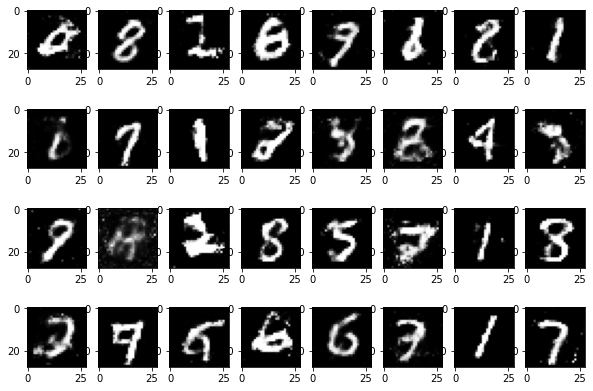

In [19]:
fig1 = plt.figure(figsize=(10,7))
rows = 4
columns = 8
for i in range(output.shape[0]):
    image = output[i]
    image = image.permute(1,2,0).detach().cpu().numpy()
    fig1.add_subplot(rows, columns, i+1)
    plt.imshow(image, cmap='gray')

    